In [1]:
import numpy as np
import os
import math
import collections
import pickle
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data 
import numpy.matlib


def save_model(class_dict):
    file_obj = open("../models/NP_CNN.obj","wb")
    pickle.dump(class_dict, file_obj)
    file_obj.close()
    print("model saved to {}".format('../models/NP_CNN.obj'))

def load_model():
    file_obj = open("../models/NP_CNN.obj","rb")
    class_dict = pickle.load(file_obj)
    file_obj.close()
    print("loaded model {}".format('../models/NP_CNN.obj'))
    return class_dict

def save_learning_curve(train_error_list, test_error_list, train_loss_list, test_loss_list):
    np.save("../models/NP_CNN_train_error_list.npy", train_error_list)
    np.save("../models/NP_CNN_test_error_list.npy", test_error_list)
    np.save("../models/NP_CNN_train_loss_list.npy", train_loss_list)
    np.save("../models/NP_CNN_test_loss_list.npy", test_loss_list)
    print("data saved to {}".format('../models/'))

def robust_log(input_arg):
    if input_arg >= math.pow(10,-300):
        return math.log(input_arg)
    else:
        return -70000

class linear_layer():
    #Initialization
    def __init__(self,num_input,num_node):
        self.num_input = num_input
        self.num_node = num_node
        b = 0.01*np.ones((1,num_node))
        W_initial = np.random.normal(size=[num_input,num_node])
        self.W = np.concatenate((W_initial,b),axis=0)
        self.dldW = collections.defaultdict(float)
        self.x = collections.defaultdict(float)
        self.y = collections.defaultdict(float)
        self.dldb = collections.defaultdict(float)

    #forward pass
    def forward(self,x):
        x = np.asarray(x)
        xstar = np.concatenate((x,np.ones((x.shape[0],1))),axis=1)
        y = np.matmul(xstar,self.W)
        self.x = x
        self.y = y

        return y

    #backward pass
    def backward(self,dLdy):
        dydx = self.W
        dydx = dydx[0:-1][:]
        dydx = np.transpose(dydx)
        dLdx = np.matmul(dLdy,dydx)
        dldW = np.matmul(np.transpose(self.x),dLdy)
        self.dldW = dldW
        self.dldb = np.matmul(np.ones((1,self.x.shape[0])),dLdy)

        return dLdx

    def update_func(self,learning_rate):
        self.W[:-1] = self.W[:-1] - learning_rate*self.dldW
        self.W[-1] = self.W[-1] - learning_rate*self.dldb


#RELU class is a class build for non-linearity for both forward and backward passing

class relu_layer():
    #Initialization
    def __init__(self,num_relu_nodes):
        self.num_relu_nodes = num_relu_nodes
        self.x = collections.defaultdict(float)
    
    def forward(self,x):
        x_array = np.array(x)
        self.x = x_array
        compare_matrix = np.zeros(np.shape(x_array))
        y = np.maximum(x_array,compare_matrix)

        return y

    def backward(self,dLdy):
        dydx = self.x
        dydx[dydx>0] = 1
        dydx[dydx<0] = 0
        #only propagate those which are selected
        dLdx = np.multiply(dLdy,dydx)

        return dLdx

#class for back propagation
class soft_max_cross_entropy_layer():
    def __init__(self,num_input,num_class):

        self.input = collections.defaultdict(float)
        self.target = np.zeros((1,num_class))
        self.output = np.zeros((1,num_class))
        self.loss = collections.defaultdict(float)

    #forward pass
    def forward(self,input,target):
        self.input = np.array(input)
        self.target = np.array(target)
        dim_max = np.reshape(np.amax(self.input,axis=1),[-1,1])
        input_adjusted = np.subtract(self.input,np.matlib.repmat(dim_max,1,self.input.shape[1]))
        self.output = self.softmax(input_adjusted)
        log_output = np.log(self.output+1e-10)
        self.loss = -np.mean(np.sum(np.multiply(self.target,log_output),axis=1),axis=0)

        return self.loss, self.output

    #backward passing
    def backward(self):
        dLdx = self.output - self.target

        return dLdx

    #softmax
    def softmax(self,input):
        np_input = np.array(input)
        num_dim = input.shape[1]
        exp_input = np.exp(np_input)
        norm_factor = np.matlib.repmat(np.reshape(np.sum(exp_input,axis=1),[-1,1]),1,num_dim)
        soft_max_output = np.divide(exp_input,norm_factor)

        return soft_max_output

#a function to calculate accyracy
def accuracy(y_pred, y_train):
    a = y_pred
    b = y_train
    return sum(np.equal(np.argmax(a, axis=1), np.argmax(b, axis=1)))/b.shape[0]



class conv_layer_2d():
    # define the initialization function
    def __init__(self,num_kernel_size,num_stride,input_channel,output_channel,padding_mode):

        self.kernel_height = num_kernel_size[0]
        self.kernel_width = num_kernel_size[1]
        self.height_stride = num_stride[0]
        self.width_stride = num_stride[1]
        self.padding_mode = padding_mode
        self.input_height = 0
        self.input_width = 0
        self.input_height_padded = 0
        self.input_width_padded = 0
        self.input_channel = input_channel
        self.output_height = 0
        self.output_width = 0
        self.output_channel = output_channel
        # initialize weights
        self.weight = np.random.normal(size=[self.input_channel,self.kernel_height,self.kernel_width,self.output_channel])
        # for gradient variables
        self.dydw = 0
        self.dldw = 0
        self.dldx = 0
        # padding legnth
        self.pad_top = 0
        self.pad_bottom = 0
        self.pad_left = 0
        self.pad_right = 0

    def forward(self,data):

        assert len(data.shape) == 4
        num_data = data.shape[0]
        self.input_height = data.shape[1]
        self.input_width = data.shape[2]
        self.input_channel = data.shape[3]

        if self.padding_mode == 'SAME':     # similar to tensorflow, here we allow different padding to different dimensions
            self.output_height = math.ceil((float)(self.input_height)/(float)(self.height_stride))
            self.output_width = math.ceil((float)(self.input_width)/(float)(self.width_stride))
        elif self.padding_mode == 'VALID':     # no padding for the 'VALID' option
            self.output_height = math.ceil((float)(self.input_height-self.kernel_height+1)/(float)(self.height_stride))
            self.output_width = math.ceil((float)(self.input_width-self.kernel_width+1)/(float)(self.width_stride))
        else:
            raise ValueError('The padding method cannot be recognized! Please check your codes!')

            
        if(self.input_height%self.height_stride==0):
            pad_height = max(self.kernel_height-self.height_stride,0)
        else:
            pad_height = max(self.kernel_height - (self.input_height%self.height_stride), 0)

        if(self.input_width%self.width_stride==0):
            pad_width = max(self.kernel_width-self.width_stride,0)
        else:
            pad_width = max(self.kernel_width - (self.input_width%self.width_stride), 0)


        self.pad_top = pad_height//2
        self.pad_bottom = pad_height - self.pad_top

        self.pad_left = pad_width//2
        self.pad_right = pad_width - self.pad_left

        if self.padding_mode == 'SAME':
            data_padded = np.pad(data,((0,0),(self.pad_top,self.pad_bottom),(self.pad_left,self.pad_right),(0,0)),'constant',constant_values=0)
        else:
            data_padded = np.pad(data,((0,0),(0,0),(0,0),(0,0)),'constant',constant_values=0)   # to keep the formation the same
        self.input_height_padded = data_padded.shape[1]
        self.input_width_padded = data_padded.shape[2]
        
        prod_tensor_inverse = np.zeros(shape=[self.output_channel,self.output_height,self.output_width, 
                                    self.input_height_padded,self.input_width_padded,self.input_channel])
        
        dydw_tensor_invere = np.zeros(shape=[self.output_height,self.output_width, num_data,
                                    self.kernel_height,self.kernel_width,self.input_channel])
        
        weight_trans = np.transpose(self.weight,(3,1,2,0))
        
        for conv_channel in range(self.output_channel):
            for conv_row_out in range(self.output_height):
                for conv_column_out in range(self.output_width):
                    this_start_row = conv_row_out*self.height_stride
                    this_end_row = this_start_row + self.kernel_height
                    this_start_col = conv_column_out*self.width_stride
                    this_end_col = this_start_col + self.kernel_width
                    prod_tensor_inverse[conv_channel,conv_row_out,conv_column_out,this_start_row:this_end_row,this_start_col:this_end_col] = weight_trans[conv_channel]
                    if conv_channel == 0:
                        dydw_tensor_invere[conv_row_out,conv_column_out] = data_padded[:,this_start_row:this_end_row,this_start_col:this_end_col,:]

        self.dydw = np.transpose(dydw_tensor_invere,(2,1,0,3,4,5))
        
        self.dydx = np.transpose(prod_tensor_inverse,(0,2,1,3,4,5))
        
        prod_tensor = np.transpose(prod_tensor_inverse,(5,4,3,1,2,0))

        conv_data = np.tensordot(data_padded,prod_tensor,axes=([3,2,1],[0,1,2]))

        return conv_data

    def backward(self,dldy):
        num_data = dldy.shape[0]

        dldy_inv_weight = np.transpose(dldy,(3,1,2,0))        
        
        dldw_inv  = np.tensordot(dldy_inv_weight,self.dydw,axes=([3,2,1],[0,1,2]))
        self.dldw = np.transpose(dldw_inv,(3,1,2,0))

        dldx_padded = np.tensordot(dldy,self.dydx,axes=([3,2,1],[0,1,2]))  

        self.dldx = dldx_padded[:,self.pad_top:self.pad_top+self.input_height,self.pad_left:self.pad_left+self.input_width,:]

        return self.dldx

    def update_func(self,learning_rate=1e-3):
        self.weight = self.weight - learning_rate*self.dldw

# class for max-pooling
class max_pooling_2d():

    def __init__(self,num_kernel_size,num_stride,padding_mode):
        self.kernel_height = num_kernel_size[0]
        self.kernel_width = num_kernel_size[1]
        self.height_stride = num_stride[0]
        self.width_stride = num_stride[1]
        self.padding_mode = padding_mode
        self.input_height = 0
        self.input_width = 0
        self.input_height_padded = 0
        self.input_width_padded = 0
        self.num_channel = 0

        self.dydx = 0
        self.dldx = 0

        self.pad_top = 0
        self.pad_bottom = 0
        self.pad_left = 0
        self.pad_right = 0

    def forward(self,data):

        num_data = data.shape[0]
        self.input_height = data.shape[1]
        self.input_width = data.shape[2]
        self.num_channel = data.shape[3]

        if self.padding_mode == 'SAME':     
            self.output_height = math.ceil((float)(self.input_height)/(float)(self.height_stride))
            self.output_width = math.ceil((float)(self.input_width)/(float)(self.width_stride))
        elif self.padding_mode == 'VALID':
            self.output_height = math.ceil((float)(self.input_height-self.kernel_height+1)/(float)(self.height_stride))
            self.output_width = math.ceil((float)(self.input_width-self.kernel_width+1)/(float)(self.width_stride))


        if(self.input_height%self.height_stride==0):
            pad_height = max(self.kernel_height-self.height_stride,0)
        else:
            pad_height = max(self.kernel_height - (self.input_height%self.height_stride), 0)

        if(self.input_width%self.width_stride==0):
            pad_width = max(self.kernel_width-self.width_stride,0)
        else:
            pad_width = max(self.kernel_width - (self.input_width%self.width_stride), 0)

        self.pad_top = pad_height//2
        self.pad_bottom = pad_height - self.pad_top
        
        self.pad_left = pad_width//2
        self.pad_right = pad_width - self.pad_left
        
        if self.padding_mode == 'SAME':
            data_padded = np.pad(data,((0,0),(self.pad_top,self.pad_bottom),(self.pad_left,self.pad_right),(0,0)),mode='constant',constant_values=0)
        else:
            data_padded = np.pad(data,((0,0),(0,0),(0,0),(0,0)),mode='constant',constant_values=0)
        self.input_height_padded = data_padded.shape[1]
        self.input_width_padded = data_padded.shape[2]

        inv_pooled_tensor = np.zeros(shape=[self.output_height,self.output_width,num_data,self.num_channel])
        
        dydx_mask_inv_tensor = np.zeros(shape=[self.output_height,self.output_width,num_data,self.num_channel,self.input_height_padded,self.input_width_padded])

        for cRow in range(self.output_height):
            for cCol in range(self.output_width):
                this_start_row = cRow*self.height_stride
                this_end_row = this_start_row + self.kernel_height
                this_start_col = cCol*self.width_stride
                this_end_col = this_start_col + self.kernel_width

                this_image_crop = data_padded[:,this_start_row:this_end_row,this_start_col:this_end_col,:]    # [num_data * kernel_height * kernel_width * num_channel]
                this_image_crop_inv = np.transpose(this_image_crop,(0,2,3,1))                                 # [num_data * num_channel * kernel_height * kernel_width]
                this_image_crop_inv_flatten = np.reshape(this_image_crop_inv,[num_data,self.num_channel,-1])        # [num_data * num_channel * (kernel_height * kernel_width)]
                inv_pooled_tensor[cRow,cCol] = np.amax(this_image_crop_inv_flatten,axis=2)        # [num_data * num_channel]

                ind_max_pixel = np.reshape(np.argmax(this_image_crop_inv_flatten,axis=2),[num_data,self.num_channel,1])

                this_one_hot_mask = np.zeros(shape=this_image_crop_inv_flatten.shape)
                this_one_hot_mask[:,:,ind_max_pixel] = 1
                this_one_hot_mask = np.reshape(this_one_hot_mask,[num_data,self.num_channel,self.kernel_height,self.kernel_width])   # [num_data * num_channel * kernel_height * kernel_width]

                dydx_mask_inv_tensor[cRow,cCol,:,:,this_start_row:this_end_row,this_start_col:this_end_col] = this_one_hot_mask[:]
        self.dydx = np.transpose(dydx_mask_inv_tensor,(2,0,1,4,5,3))
        pooling_output = np.transpose(inv_pooled_tensor,(2,0,1,3))

        return pooling_output

    def backward(self,dldy):
        assert len(dldy.shape)==4
        num_data = dldy.shape[0]

        dldy_compute_inv = np.zeros(shape=[self.input_height_padded,self.input_width_padded,num_data,self.output_height,self.output_width,self.num_channel])
        dldy_compute_inv[:,:] = dldy
        dldy_compute = np.transpose(dldy_compute_inv,(2,3,4,0,1,5))     # [num_data * nHeight_out * nWidth_out * nHeight_padded * nWidth_padded * num_channel]

        dldx_tensor = np.einsum('...,...->...',dldy_compute,self.dydx)

        self.dydx = np.sum(np.sum(dldx_tensor,axis=1),axis=1)

        return self.dydx

#calculate training errors


def get_error_loss_and_pred(inter_data, label):

    for conv_layer in range(len(conv_layer_list)):
        inter_data = conv_layer_list[conv_layer].forward(inter_data)
        if (conv_layer+1) in pool_operationum_layers:
                this_pooling_ind = pool_operationum_layers.index(conv_layer+1)
                inter_data = pool_layer_list[this_pooling_ind].forward(inter_data)
    
    batch_image_out_shape = inter_data.shape
    
    inter_data = np.reshape(inter_data,[-1,flattenum_size])
    inter_data = linear_layer_1.forward(inter_data)
    inter_data = nonum_linear_layer_1.forward(inter_data)
    z_out = linear_layer_2.forward(inter_data)
    
    
    loss, softmax_predict = loss_layer.forward(z_out,label)
    error = 1 - accuracy(softmax_predict, label)
    return error, loss, softmax_predict

In [2]:
data_dir = '../data'
mnist = input_data.read_data_sets(data_dir, one_hot=True)

train_image = mnist.train.images
train_label = mnist.train.labels
test_image = mnist.test.images
test_label = mnist.test.labels

train_image_feed = np.reshape(train_image,[-1,28,28,1])
test_image_feed = np.reshape(test_image,[-1,28,28,1])

num_data_train = train_image_feed.shape[0]
num_data_test = test_image_feed.shape[0]


conv_kernel_size_list = [(3,3),(3,3)]
# conv_stride_size_list = [(1,1),(1,1)]
conv_stride_size_list = [(2,2),(2,2)]
# pool_operationum_layers = [1,2]
pool_operationum_layers = []

pooling_kernel_size_list = [(2,2),(2,2)]
pooling_stride_size_list = [(2,2),(2,2)]
image_channels = [1,3,9]
flattenum_size = 7*7*image_channels[-1]
num_linear_node = 100
num_class = 10

batch_size = 32
learning_rate = 1e-3
cnnum_learning_rate = 1e-4

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [3]:
class_dict = load_model()
conv_layer_list = class_dict["conv_layer_list"]
pool_layer_list = class_dict["pool_layer_list"]
linear_layer_1 = class_dict["linear_layer_1"]
nonum_linear_layer_1 = class_dict["nonum_linear_layer_1"]
linear_layer_2 = class_dict["linear_layer_2"]
loss_layer = class_dict["loss_layer"]

train_error, train_loss, y_train_pred = get_error_loss_and_pred(train_image_feed, train_label)
test_error, test_loss, y_test_pred = get_error_loss_and_pred(test_image_feed, test_label)

print("train error = {:.6f}, test error = {:.6f}, train_loss = {:.6f}, test loss = {:.6f}".format(train_error, test_error, train_loss, test_loss))    

loaded model ../models/NP_CNN.obj
train error = 0.020964, test error = 0.033200, train_loss = 0.067500, test loss = 0.112121


In [4]:
y_train = train_label
y_test = test_label

from sklearn.metrics import confusion_matrix

train_pred = np.argmax(y_train_pred, axis=1)
train_labels = np.argmax(y_train, axis=1)

test_pred = np.argmax(y_test_pred, axis=1)
test_labels = np.argmax(y_test, axis=1)

train_confuse = confusion_matrix(train_labels, train_pred)
test_confuse = confusion_matrix(test_labels, test_pred)

In [5]:
train_confuse

array([[5386,    0,    3,    3,    3,   11,    8,    3,   13,   14],
       [   1, 6129,   15,    5,    0,    0,    5,    9,   11,    4],
       [  14,    5, 5367,   22,   14,    5,    1,   19,   16,    7],
       [   6,    4,   42, 5425,    1,   62,    0,   14,   45,   39],
       [   1,    5,    8,    4, 5217,    2,    3,    5,    5,   57],
       [   3,    1,    3,   26,    8, 4873,   16,    4,   21,   32],
       [  17,    3,    4,    0,   18,   26, 5338,    0,   10,    1],
       [   2,   13,   20,   10,   24,    4,    0, 5580,    5,   57],
       [  12,   18,   15,   41,    4,   31,    5,   10, 5218,   35],
       [   4,    5,    3,   14,   48,   16,    0,   34,   16, 5314]])

In [6]:
test_confuse

array([[ 963,    0,    2,    0,    2,    3,    4,    0,    1,    5],
       [   0, 1124,    1,    1,    0,    1,    2,    1,    5,    0],
       [   5,    2,  994,    8,    3,    2,    1,    4,   13,    0],
       [   1,    0,    7,  982,    0,    6,    0,    3,    5,    6],
       [   2,    1,    5,    0,  956,    0,    2,    1,    1,   14],
       [   3,    0,    0,   15,    2,  857,    6,    2,    4,    3],
       [   9,    1,    3,    1,   10,   12,  916,    0,    5,    1],
       [   0,    7,   13,    2,    6,    0,    0,  983,    3,   14],
       [   4,    2,    5,   13,    3,    9,    1,    2,  927,    8],
       [   1,    2,    2,    5,   13,    5,    1,    8,    6,  966]])

training confusion matrix
Confusion matrix, without normalization


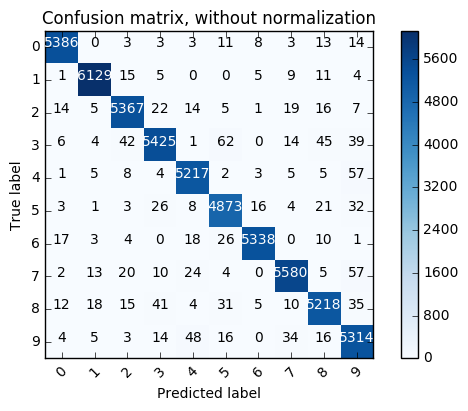

testing confusion matrix
Confusion matrix, without normalization


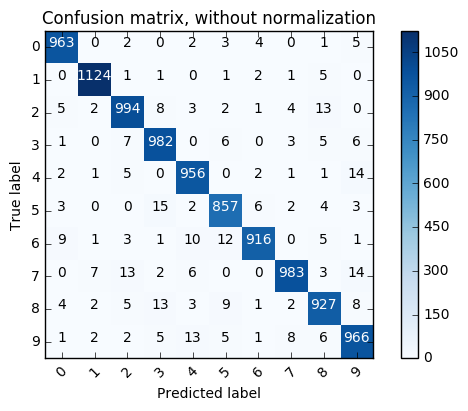

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
print("training confusion matrix")
plt.figure()
plot_confusion_matrix(train_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print("testing confusion matrix")
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

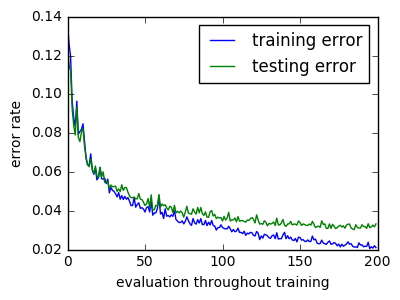

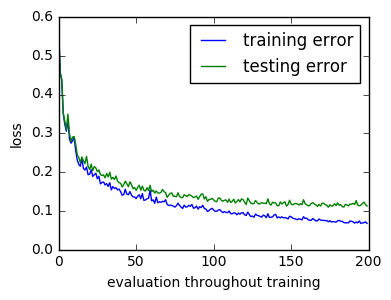

In [8]:
train_error_list = np.load("../models/NP_CNN_train_error_list.npy")
test_error_list = np.load("../models/NP_CNN_test_error_list.npy")
train_loss_list = np.load("../models/NP_CNN_train_loss_list.npy")
test_loss_list = np.load("../models/NP_CNN_test_loss_list.npy")


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_error_list)
plt.plot(test_error_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("error rate")
plt.legend(["training error", "testing error"])
plt.show()


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("loss")
plt.legend(["training error", "testing error"])
plt.show()

In [9]:
print("""
\\begin{table}[H]
\t\\centering
\t\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\t\t\\hline
\t\ttrain epoch\\textbackslash error & train error & test error \\\\
\t\t\\hline
""")
for i in range(10):
    print("\t\t{} & {:.4f} & {:.4f} \\\\".format(int(len(train_error_list) * i/10), train_error_list[int(len(train_error_list) * i/10)], test_error_list[int(len(train_error_list) * i/10)]))
    print("\t\t\\hline")
print("\t\t{} & {:.4f} & {:.4f} \\\\".format(len(train_error_list)-1, train_error_list[-1], test_error_list[-1]))
print("\t\t\\hline")
print("""
\t\\end{tabular}
\t\\caption{training and testing error}
\t\\label{tab:my_label}
\\end{table}
""")


\begin{table}[H]
	\centering
	\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
		\hline
		train epoch\textbackslash error & train error & test error \\
		\hline

		0 & 0.1363 & 0.1253 \\
		\hline
		20 & 0.0574 & 0.0569 \\
		\hline
		40 & 0.0450 & 0.0477 \\
		\hline
		60 & 0.0383 & 0.0419 \\
		\hline
		80 & 0.0324 & 0.0382 \\
		\hline
		100 & 0.0313 & 0.0347 \\
		\hline
		120 & 0.0273 & 0.0355 \\
		\hline
		140 & 0.0288 & 0.0326 \\
		\hline
		160 & 0.0254 & 0.0313 \\
		\hline
		180 & 0.0228 & 0.0326 \\
		\hline
		199 & 0.0210 & 0.0332 \\
		\hline

	\end{tabular}
	\caption{training and testing error}
	\label{tab:my_label}
\end{table}

